Train: (6, 5) Val: (2, 5) Test: (2, 5)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 0.1111 - accuracy: 0.3333 - loss: 0.9193 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8671
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.9679 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8584
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - AUC: 0.0000e+00 - accuracy: 0.3333 - loss: 0.8272 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8500
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - AUC: 0.0000e+00 - accuracy: 0.1667 - loss: 0.8707 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8414
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - AUC: 0.3333 - accuracy: 0.1667 - loss: 0.7971 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.8327
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - AUC: 0.0556 - accuracy: 0.1667 - loss: 0.9312 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - va

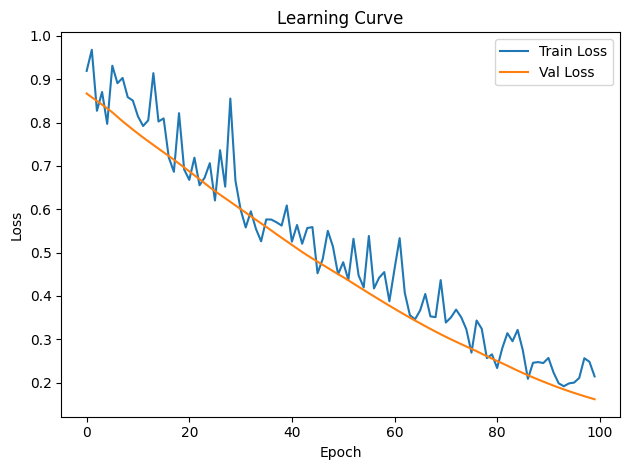

In [6]:
# === Artificial Neural Network untuk Prediksi Kelulusan ===

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === 1. Load dataset ===
df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

# === 2. Split data dengan stratify (agar seimbang) ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# === 3. Standarisasi ===
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# === 4. Model Neural Network ===
import tensorflow as tf
from tensorflow.keras import layers, callbacks

model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)

model.summary()

# === 5. Early Stopping ===
es = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# === 6. Training ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# === 7. Evaluasi ===
from sklearn.metrics import classification_report, confusion_matrix

loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print("\nTest Accuracy:", acc)
print("Test AUC:", auc)

y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# === 8. Visualisasi Learning Curve ===
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve")
plt.tight_layout()
plt.savefig("learning_curve_fixed.png", dpi=120)
plt.show()
